In [13]:
# IMPORTS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time
import warnings
warnings.filterwarnings('ignore')

# For preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

# For classification
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

# For metrics
from sklearn.metrics import (
    confusion_matrix, roc_curve, auc, f1_score, accuracy_score,
    classification_report, precision_recall_curve, roc_auc_score
)

# For clustering
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.decomposition import TruncatedSVD

# For optimization
import multiprocessing

# Set random seed
np.random.seed(42)

# Filepaths
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/test-and-training-data/Training.csv
/kaggle/input/test-and-training-data/Test.csv


In [2]:
# DEFINE ALL GENERAL FUNCTIONS HERE

def preprocess_data(df):
    """
    Preprocess the DataFrame by cleaning and preparing for analysis.

    - Fills missing 'reviewText' with an empty string.
    - Removes rows with empty 'reviewText'.
    - Converts 'overall' to int if it exists.
    - Keeps only ['overall', 'reviewText', 'category'] columns if they exist.
    """
    processed_df = df.copy()
    
    if 'reviewText' in processed_df.columns:
        processed_df['reviewText'] = processed_df['reviewText'].fillna('')
        processed_df = processed_df[processed_df['reviewText'].str.len() > 0]
    
    if 'overall' in processed_df.columns:
        processed_df['overall'] = processed_df['overall'].astype(int)
    
    # Accept either 'Category' or 'category' if present
    possible_cols = ['overall', 'reviewText', 'category']
    keep_cols = [col for col in possible_cols if col in processed_df.columns]
    processed_df = processed_df[keep_cols]
    
    return processed_df


def create_text_features(train_data, test_data=None, max_features=10000, ngram_range=(1, 2)):
    """
    Create text features using a TF-IDF vectorizer.
    
    Parameters:
    -----------
    train_data : pandas Series
        Training text data
    test_data : pandas Series, optional
        Test text data
    max_features : int
        Maximum number of features to use in vectorization
    ngram_range : tuple
        Lower and upper boundary for n-gram range
        
    Returns:
    --------
    train_features : scipy sparse matrix
    test_features : scipy sparse matrix or None
    vectorizer : TfidfVectorizer
    """
    print("Extracting text features using TF-IDF...")
    vectorizer = TfidfVectorizer(
        max_features=max_features,
        ngram_range=ngram_range,
        min_df=2,
        max_df=0.9,
        strip_accents='unicode',
        sublinear_tf=True
    )
    
    train_features = vectorizer.fit_transform(train_data)
    
    if test_data is not None:
        print("Transforming test data...")
        test_features = vectorizer.transform(test_data)
        return train_features, test_features, vectorizer
    else:
        return train_features, vectorizer, None


def create_binary_labels(ratings, cutoff):
    """
    Convert ratings to binary labels based on the given cutoff.
    Label = 1 if rating > cutoff, else 0.
    """
    return (ratings > cutoff).astype(int)


def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, normalize=False):
    """
    Plot a confusion matrix. If normalize=True, displays proportions instead of raw counts.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
    else:
        fmt = 'd'
    
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


def plot_roc_curve(y_true, y_score, title='ROC Curve'):
    """
    Plot ROC curve for binary classification and return the AUC.
    """
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()
    
    return roc_auc


def evaluate_classifier(clf, X_test, y_test, class_names=['Negative', 'Positive']):
    """
    Evaluate a classifier (binary or multiclass) and print/plot metrics.
    
    For binary:
    - class_names defaults to ['Negative', 'Positive'].
    For multiclass, provide a list of class_names = ['1', '2', '3', '4', '5'] or similar.
    """
    y_pred = clf.predict(X_test)
    
    # Handle decision_function or predict_proba for scores
    if hasattr(clf, "predict_proba"):
        y_score = clf.predict_proba(X_test)
        # For binary classification, we'll use y_score[:,1]
        # For multiclass, we might handle differently in a separate function
    else:
        # Some models (like LinearSVC) only have decision_function
        if hasattr(clf, "decision_function"):
            y_score = clf.decision_function(X_test)
        else:
            y_score = None
    
    accuracy = accuracy_score(y_test, y_pred)
    # For multiclass or binary, 'macro' is a fair aggregator for F1
    f1 = f1_score(y_test, y_pred, average='macro')
    cm = confusion_matrix(y_test, y_pred)
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Macro F1 Score: {f1:.4f}\n")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion matrix (counts)
    plot_confusion_matrix(cm, classes=class_names, title='Confusion Matrix (Counts)', normalize=False)
    
    if (y_score is not None) and (len(np.unique(y_test)) == 2):
        if len(y_score.shape) > 1 and y_score.shape[1] == 2:
            auc_score = plot_roc_curve(y_test, y_score[:, 1], title='ROC Curve')
        else:
            auc_score = plot_roc_curve(y_test, y_score, title='ROC Curve')
    else:
        auc_score = None
    
    return {
        'accuracy': accuracy,
        'f1_score': f1,
        'confusion_matrix': cm,
        'auc': auc_score
    }


def train_binary_classifier(X_train, y_train, model_type, param_grid, cv=5, n_jobs=-1):
    """
    Train a binary classifier using GridSearchCV for hyperparameter tuning.
    
    model_type can be 'lr', 'svm', or 'nb'.
    """
    if model_type == 'lr':
        model = LogisticRegression(random_state=42, max_iter=1000)
    elif model_type == 'svm':
        model = LinearSVC(random_state=42, max_iter=1000, dual=False)
    elif model_type == 'nb':
        model = MultinomialNB()
    
    stratified_cv = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=stratified_cv,
        scoring='f1_macro',
        n_jobs=n_jobs,
        verbose=1,
        return_train_score=True
    )
    
    start_time = time.time()
    print(f"Training {model_type} classifier...")
    grid_search.fit(X_train, y_train)
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds.")
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation F1 (macro): {grid_search.best_score_:.4f}")
    
    return grid_search.best_estimator_, grid_search.cv_results_


In [3]:
# PREPARE DATA

print("Loading training data...")
try:
    train_df = pd.read_csv('Training.csv')
    print(f"Training data loaded with shape: {train_df.shape}")
except FileNotFoundError:
    # Adjust path if needed (Kaggle fallback)
    train_df = pd.read_csv('/kaggle/input/test-and-training-data/Training.csv')
    print(f"Training data loaded from Kaggle with shape: {train_df.shape}")

processed_train = preprocess_data(train_df)
print(f"Processed training data shape: {processed_train.shape}")

print("Loading test data...")
has_test_data = True
try:
    test_df = pd.read_csv('Test.csv')
    print(f"Test data loaded with shape: {test_df.shape}")
except FileNotFoundError:
    # Adjust path if needed (Kaggle fallback)
    try:
        test_df = pd.read_csv('/kaggle/input/test-and-training-data/Test.csv')
        print(f"Test data loaded from Kaggle with shape: {test_df.shape}")
    except FileNotFoundError:
        print("Test.csv not found. Will run experiments without test data.")
        test_df = None
        has_test_data = False

if has_test_data and (test_df is not None):
    processed_test = preprocess_data(test_df)
    print(f"Processed test data shape: {processed_test.shape}")
else:
    processed_test = None

# Basic info about training data
print("\nBasic information about the training data:")
if 'overall' in processed_train.columns:
    print("Sample counts per rating:")
    print(processed_train['overall'].value_counts().sort_index())

print("\nMissing values per column:")
print(processed_train.isnull().sum())

# Create TF-IDF features
if has_test_data and (processed_test is not None) and ('reviewText' in processed_test.columns):
    X_train_features, X_test_features, vectorizer = create_text_features(
        processed_train['reviewText'],
        processed_test['reviewText'],
        max_features=10000
    )
else:
    X_train_features, vectorizer, X_test_features = create_text_features(
        processed_train['reviewText'],
        test_data=None,
        max_features=10000
    )

print(f"Training features shape: {X_train_features.shape}")
if X_test_features is not None:
    print(f"Test features shape: {X_test_features.shape}")

# Extract numeric ratings from training set
if 'overall' in processed_train.columns:
    y_ratings = processed_train['overall'].values
else:
    y_ratings = None

print(f"\nUsing {multiprocessing.cpu_count() - 1} CPU cores for parallel processing.")

Loading training data...
Training data loaded from Kaggle with shape: (29189, 13)
Processed training data shape: (29189, 3)
Loading test data...
Test data loaded from Kaggle with shape: (4500, 12)
Processed test data shape: (4500, 2)

Basic information about the training data:
Sample counts per rating:
overall
1    5957
2    5959
3    5862
4    5769
5    5642
Name: count, dtype: int64

Missing values per column:
overall       0
reviewText    0
category      0
dtype: int64
Extracting text features using TF-IDF...
Transforming test data...
Training features shape: (29189, 10000)
Test features shape: (4500, 10000)

Using 3 CPU cores for parallel processing.



Binary Classification Experiment (Cutoff = 1)
Training samples: 23351
Validation samples: 5838
Positive class ratio (overall > 1): 0.7959

Training Logistic Regression...
Training lr classifier...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Training completed in 18.09 seconds.
Best parameters: {'C': 1.0, 'class_weight': 'balanced', 'solver': 'saga'}
Best cross-validation F1 (macro): 0.7468

Logistic Regression Evaluation:
Accuracy: 0.7982
Macro F1 Score: 0.7333

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.75      0.60      1191
           1       0.93      0.81      0.86      4647

    accuracy                           0.80      5838
   macro avg       0.71      0.78      0.73      5838
weighted avg       0.84      0.80      0.81      5838



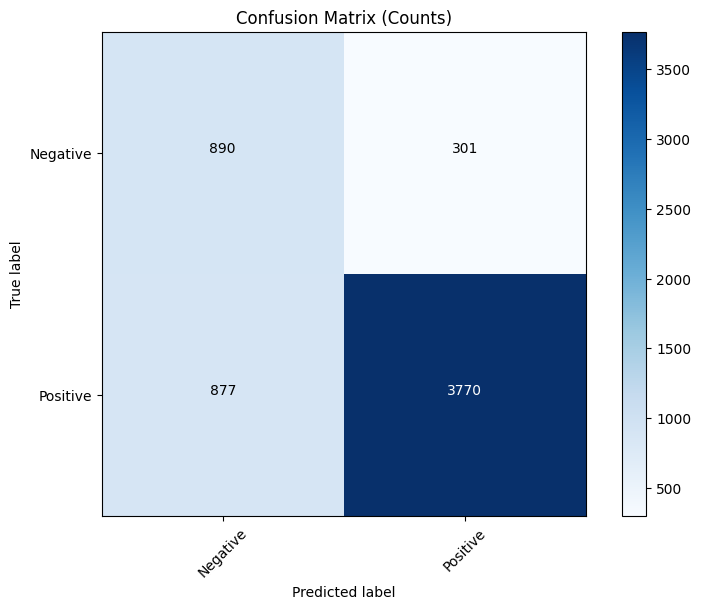

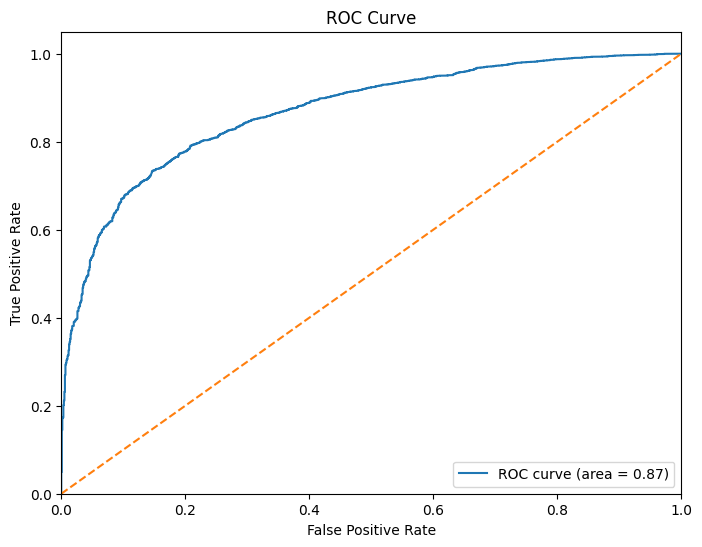


Training Linear SVM...
Training svm classifier...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Training completed in 8.63 seconds.
Best parameters: {'C': 0.1, 'class_weight': 'balanced', 'loss': 'squared_hinge'}
Best cross-validation F1 (macro): 0.7457

Linear SVM Evaluation:
Accuracy: 0.7972
Macro F1 Score: 0.7329

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.75      0.60      1191
           1       0.93      0.81      0.86      4647

    accuracy                           0.80      5838
   macro avg       0.71      0.78      0.73      5838
weighted avg       0.84      0.80      0.81      5838



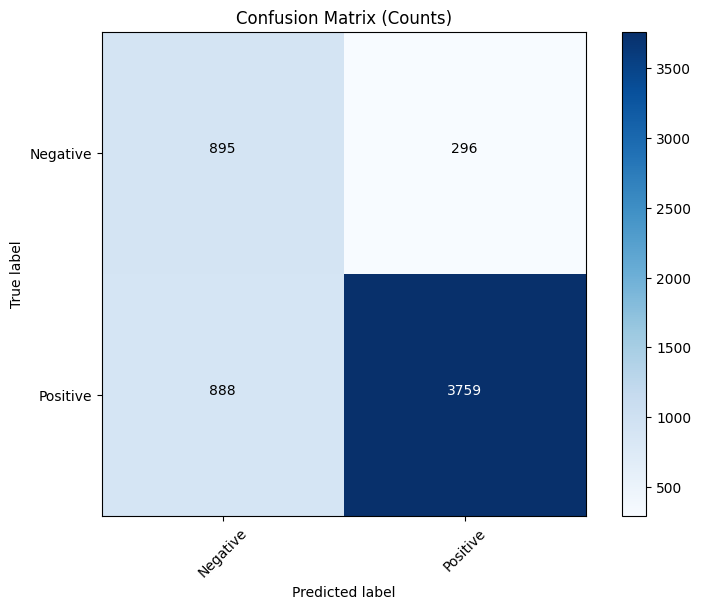

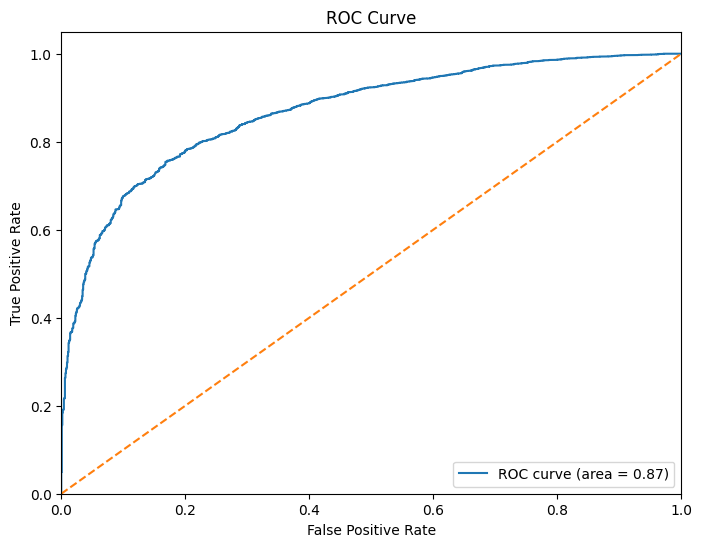


Training Naive Bayes...
Training nb classifier...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Training completed in 0.51 seconds.
Best parameters: {'alpha': 0.01}
Best cross-validation F1 (macro): 0.6477

Naive Bayes Evaluation:
Accuracy: 0.8285
Macro F1 Score: 0.6415

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.26      0.38      1191
           1       0.84      0.97      0.90      4647

    accuracy                           0.83      5838
   macro avg       0.78      0.62      0.64      5838
weighted avg       0.81      0.83      0.79      5838



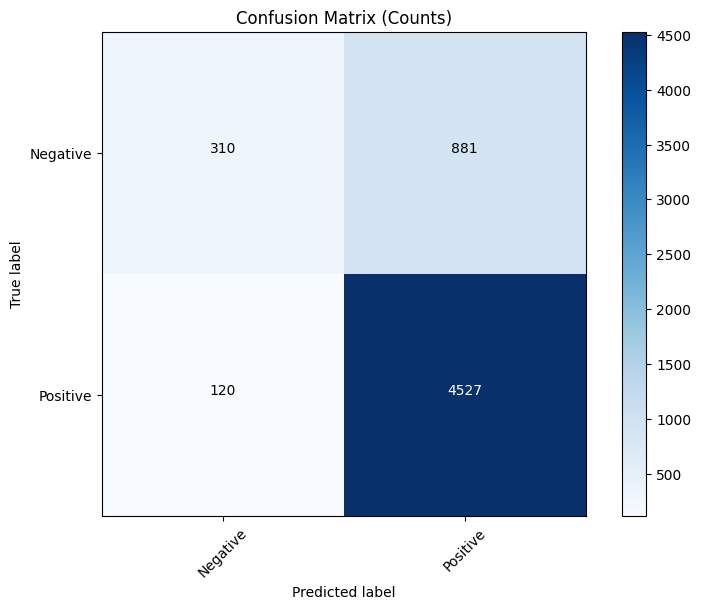

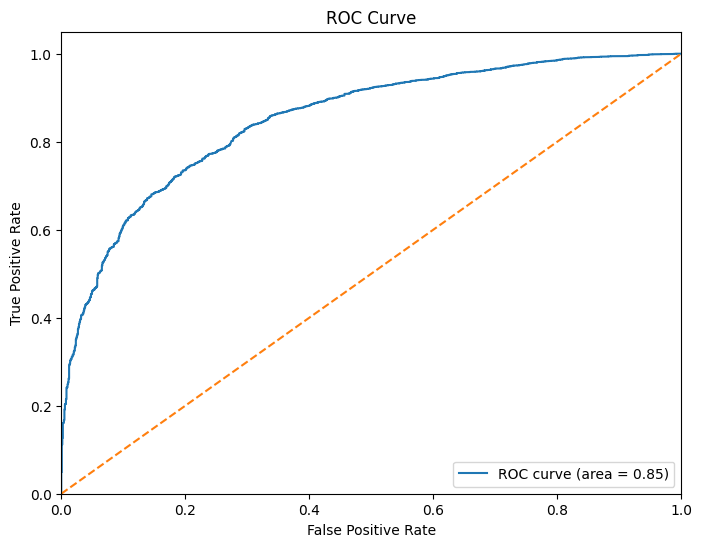


Model Comparison (Macro F1 Score):
LR: 0.7333
SVM: 0.7329
NB: 0.6415

BEST MODEL FOR BINARY CLASSIFICATION (CUTOFF = 1): LR
Macro F1 Score: 0.7333
Predictions for cutoff=1 saved to 'binary_predictions_cutoff_1.csv'.


In [4]:
# BINARY CLASSIFICATION CUTOFF 1

def binary_classification_cutoff_1(X, y_ratings, test_size=0.2, random_state=42):
    """
    Run binary classification experiment for cutoff = 1.
    """
    cutoff = 1
    y_binary = create_binary_labels(y_ratings, cutoff)
    
    X_train, X_val, y_train, y_val = train_test_split(
        X, y_binary, test_size=test_size, random_state=random_state, stratify=y_binary
    )
    
    print(f"\n{'='*80}")
    print(f"Binary Classification Experiment (Cutoff = {cutoff})")
    print(f"{'='*80}")
    print(f"Training samples: {X_train.shape[0]}")
    print(f"Validation samples: {X_val.shape[0]}")
    print(f"Positive class ratio (overall > {cutoff}): {y_binary.mean():.4f}")
    
    results = {}
    
    # Logistic Regression
    print("\nTraining Logistic Regression...")
    lr_param_grid = {
        'C': [0.1, 1.0, 10.0],
        'class_weight': [None, 'balanced'],
        'solver': ['liblinear', 'saga']
    }
    lr_model, lr_cv_results = train_binary_classifier(X_train, y_train, 'lr', lr_param_grid)
    print("\nLogistic Regression Evaluation:")
    lr_metrics = evaluate_classifier(lr_model, X_val, y_val)
    results['lr'] = {'model': lr_model, 'metrics': lr_metrics, 'cv_results': lr_cv_results}
    
    # Linear SVM
    print("\nTraining Linear SVM...")
    svm_param_grid = {
        'C': [0.1, 1.0, 10.0],
        'class_weight': [None, 'balanced'],
        'loss': ['hinge', 'squared_hinge']
    }
    svm_model, svm_cv_results = train_binary_classifier(X_train, y_train, 'svm', svm_param_grid)
    print("\nLinear SVM Evaluation:")
    svm_metrics = evaluate_classifier(svm_model, X_val, y_val)
    results['svm'] = {'model': svm_model, 'metrics': svm_metrics, 'cv_results': svm_cv_results}
    
    # Naive Bayes
    print("\nTraining Naive Bayes...")
    nb_param_grid = {'alpha': [0.01, 0.1, 1.0, 10.0]}
    nb_model, nb_cv_results = train_binary_classifier(X_train, y_train, 'nb', nb_param_grid)
    print("\nNaive Bayes Evaluation:")
    nb_metrics = evaluate_classifier(nb_model, X_val, y_val)
    results['nb'] = {'model': nb_model, 'metrics': nb_metrics, 'cv_results': nb_cv_results}
    
    # Compare models by Macro F1
    print("\nModel Comparison (Macro F1 Score):")
    for model_name, model_data in results.items():
        print(f"{model_name.upper()}: {model_data['metrics']['f1_score']:.4f}")
    
    return results


# --- Run experiment for cutoff=1 ---

if y_ratings is not None:
    results_cutoff_1 = binary_classification_cutoff_1(X_train_features, y_ratings)
    best_model_name_1 = max(
        results_cutoff_1.items(),
        key=lambda x: x[1]['metrics']['f1_score']
    )[0]
    best_model_1 = results_cutoff_1[best_model_name_1]['model']
    best_f1_score_1 = results_cutoff_1[best_model_name_1]['metrics']['f1_score']
    
    print(f"\n{'='*80}")
    print(f"BEST MODEL FOR BINARY CLASSIFICATION (CUTOFF = 1): {best_model_name_1.upper()}")
    print(f"Macro F1 Score: {best_f1_score_1:.4f}")
    print(f"{'='*80}")
    if (X_test_features is not None) and (processed_test is not None):
        test_predictions = best_model_1.predict(X_test_features)
        submission_df = pd.DataFrame({
            'id': processed_test.index,
            'binary_split_1': test_predictions
        })
        submission_df.to_csv('binary_predictions_cutoff_1.csv', index=False)
        print("Predictions for cutoff=1 saved to 'binary_predictions_cutoff_1.csv'.")


Binary Classification Experiment (Cutoff = 2)
Training samples: 23351
Validation samples: 5838
Positive class ratio (overall > 2): 0.5918

Training Logistic Regression...
Training lr classifier...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Training completed in 15.44 seconds.
Best parameters: {'C': 1.0, 'class_weight': 'balanced', 'solver': 'liblinear'}
Best cross-validation F1 (macro): 0.8024

Logistic Regression Evaluation:
Accuracy: 0.8102
Macro F1 Score: 0.8052

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.80      0.77      2383
           1       0.85      0.82      0.84      3455

    accuracy                           0.81      5838
   macro avg       0.80      0.81      0.81      5838
weighted avg       0.81      0.81      0.81      5838



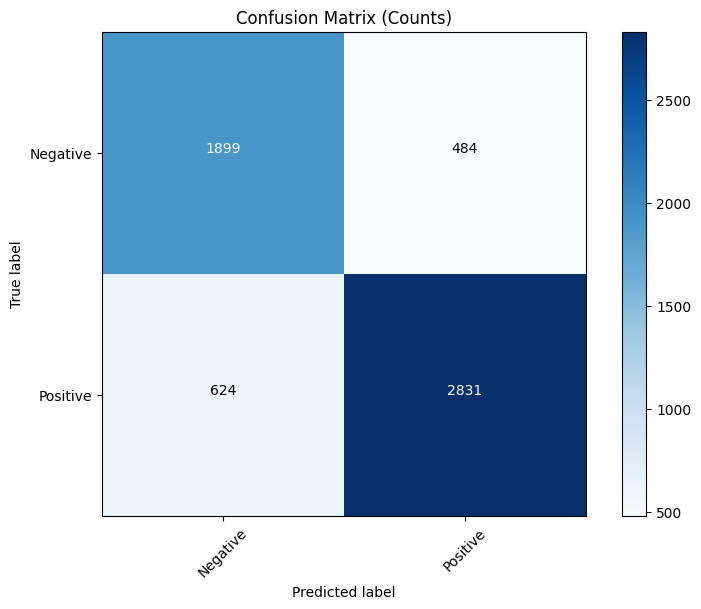

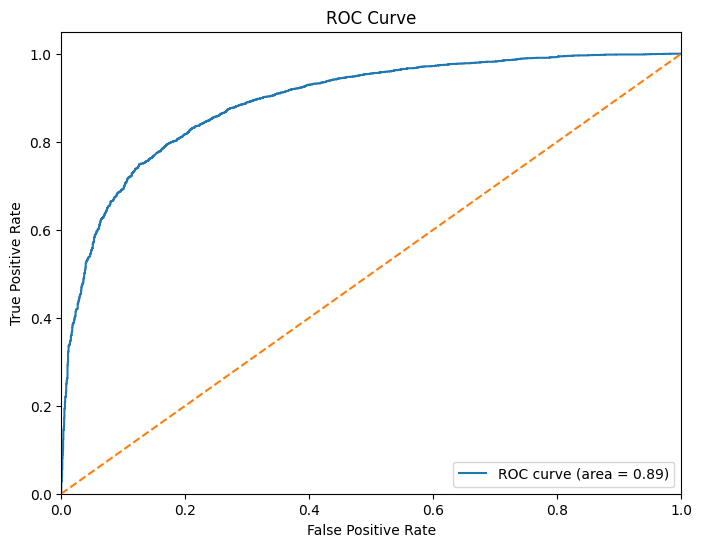


Training Linear SVM...
Training svm classifier...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Training completed in 7.91 seconds.
Best parameters: {'C': 0.1, 'class_weight': 'balanced', 'loss': 'squared_hinge'}
Best cross-validation F1 (macro): 0.8024

Linear SVM Evaluation:
Accuracy: 0.8129
Macro F1 Score: 0.8082

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.80      0.78      2383
           1       0.86      0.82      0.84      3455

    accuracy                           0.81      5838
   macro avg       0.81      0.81      0.81      5838
weighted avg       0.82      0.81      0.81      5838



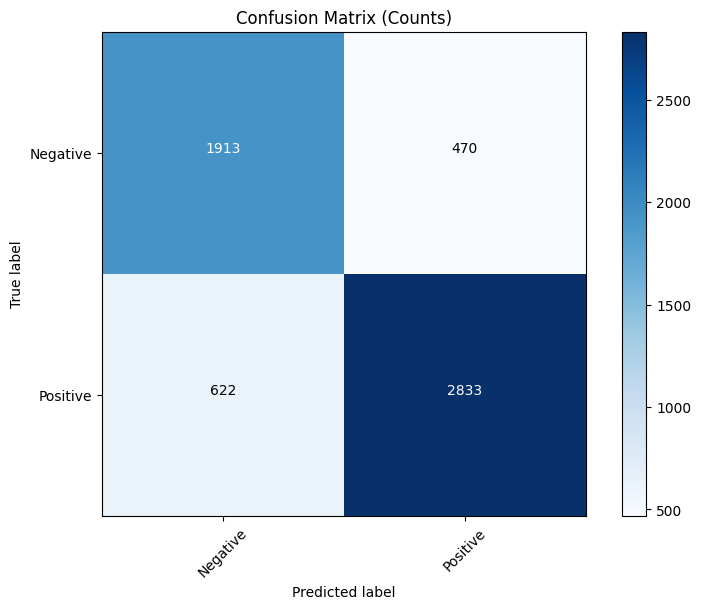

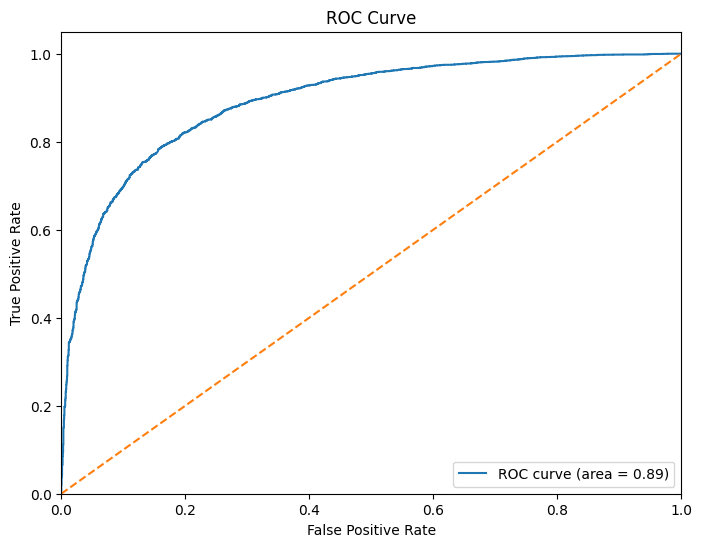


Training Naive Bayes...
Training nb classifier...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Training completed in 0.67 seconds.
Best parameters: {'alpha': 0.1}
Best cross-validation F1 (macro): 0.7828

Naive Bayes Evaluation:
Accuracy: 0.7989
Macro F1 Score: 0.7841

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.66      0.73      2383
           1       0.79      0.90      0.84      3455

    accuracy                           0.80      5838
   macro avg       0.80      0.78      0.78      5838
weighted avg       0.80      0.80      0.79      5838



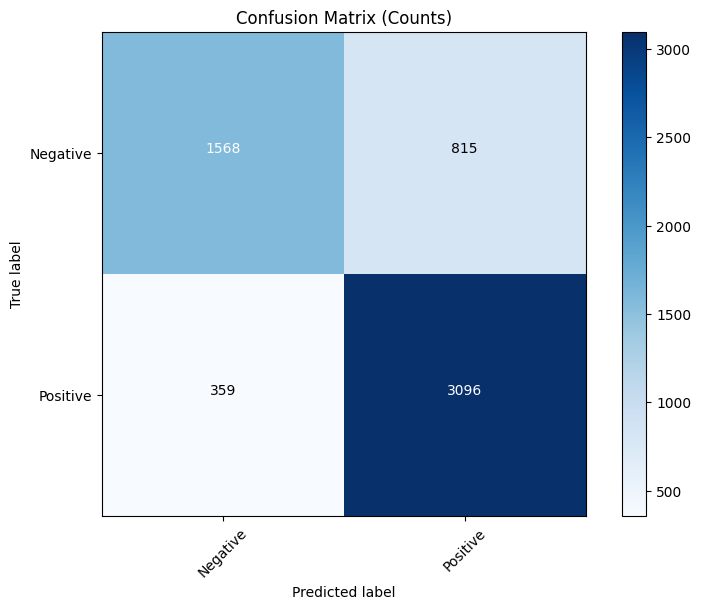

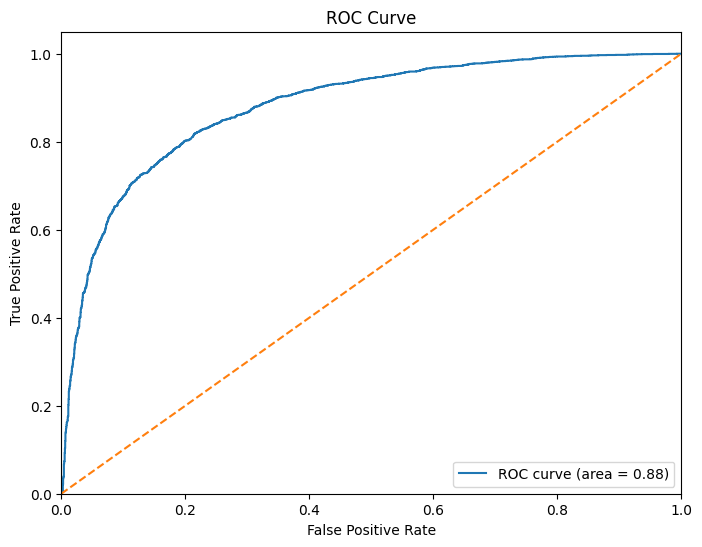


Model Comparison (Macro F1 Score):
LR: 0.8052
SVM: 0.8082
NB: 0.7841

BEST MODEL FOR BINARY CLASSIFICATION (CUTOFF = 2): SVM
Macro F1 Score: 0.8082
Sample review: "This product is decent. It works as expected, but nothing special."
Predicted label (>2 or ≤2): 1
Predictions for cutoff=2 saved to 'binary_predictions_cutoff_2.csv'.


In [5]:
# BINARY CLASSIFICATION CUTOFF = 2

def binary_classification_cutoff_2(X, y_ratings, test_size=0.2, random_state=42):
    """
    Run binary classification experiment for cutoff = 2.
    """
    cutoff = 2
    y_binary = create_binary_labels(y_ratings, cutoff)
    
    X_train, X_val, y_train, y_val = train_test_split(
        X, y_binary, test_size=test_size, random_state=random_state, stratify=y_binary
    )
    
    print(f"\n{'='*80}")
    print(f"Binary Classification Experiment (Cutoff = {cutoff})")
    print(f"{'='*80}")
    print(f"Training samples: {X_train.shape[0]}")
    print(f"Validation samples: {X_val.shape[0]}")
    print(f"Positive class ratio (overall > {cutoff}): {y_binary.mean():.4f}")
    
    results = {}
    
    # Logistic Regression
    print("\nTraining Logistic Regression...")
    lr_param_grid = {
        'C': [0.1, 1.0, 10.0],
        'class_weight': [None, 'balanced'],
        'solver': ['liblinear', 'saga']
    }
    lr_model, lr_cv_results = train_binary_classifier(X_train, y_train, 'lr', lr_param_grid)
    print("\nLogistic Regression Evaluation:")
    lr_metrics = evaluate_classifier(lr_model, X_val, y_val)
    results['lr'] = {'model': lr_model, 'metrics': lr_metrics, 'cv_results': lr_cv_results}
    
    # Linear SVM
    print("\nTraining Linear SVM...")
    svm_param_grid = {
        'C': [0.1, 1.0, 10.0],
        'class_weight': [None, 'balanced'],
        'loss': ['hinge', 'squared_hinge']
    }
    svm_model, svm_cv_results = train_binary_classifier(X_train, y_train, 'svm', svm_param_grid)
    print("\nLinear SVM Evaluation:")
    svm_metrics = evaluate_classifier(svm_model, X_val, y_val)
    results['svm'] = {'model': svm_model, 'metrics': svm_metrics, 'cv_results': svm_cv_results}
    
    # Naive Bayes
    print("\nTraining Naive Bayes...")
    nb_param_grid = {'alpha': [0.01, 0.1, 1.0, 10.0]}
    nb_model, nb_cv_results = train_binary_classifier(X_train, y_train, 'nb', nb_param_grid)
    print("\nNaive Bayes Evaluation:")
    nb_metrics = evaluate_classifier(nb_model, X_val, y_val)
    results['nb'] = {'model': nb_model, 'metrics': nb_metrics, 'cv_results': nb_cv_results}
    
    # Compare models by Macro F1
    print("\nModel Comparison (Macro F1 Score):")
    for model_name, model_data in results.items():
        print(f"{model_name.upper()}: {model_data['metrics']['f1_score']:.4f}")
    
    return results


# --- Run experiment for cutoff=2 ---

if y_ratings is not None:
    results_cutoff_2 = binary_classification_cutoff_2(X_train_features, y_ratings)
    best_model_name_2 = max(
        results_cutoff_2.items(),
        key=lambda x: x[1]['metrics']['f1_score']
    )[0]
    best_model_2 = results_cutoff_2[best_model_name_2]['model']
    best_f1_score_2 = results_cutoff_2[best_model_name_2]['metrics']['f1_score']
    
    print(f"\n{'='*80}")
    print(f"BEST MODEL FOR BINARY CLASSIFICATION (CUTOFF = 2): {best_model_name_2.upper()}")
    print(f"Macro F1 Score: {best_f1_score_2:.4f}")
    print(f"{'='*80}")
    
    # Example usage of the best model for cutoff=2 (optional)
    sample_review = "This product is decent. It works as expected, but nothing special."
    if best_model_2 is not None:
        vec_sample = vectorizer.transform([sample_review])
        pred = best_model_2.predict(vec_sample)[0]
        print(f"Sample review: \"{sample_review}\"")
        print(f"Predicted label (>2 or ≤2): {pred}")
        
    # Generate predictions for test dataset
    if (X_test_features is not None) and (processed_test is not None):
        test_predictions = best_model_2.predict(X_test_features)
        submission_df = pd.DataFrame({
            'id': processed_test.index,
            'binary_split_2': test_predictions
        })
        submission_df.to_csv('binary_predictions_cutoff_2.csv', index=False)
        print("Predictions for cutoff=2 saved to 'binary_predictions_cutoff_2.csv'.")


Binary Classification Experiment (Cutoff = 3)
Training samples: 23351
Validation samples: 5838
Positive class ratio (overall > 3): 0.3909

Training Logistic Regression...
Training lr classifier...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Training completed in 15.01 seconds.
Best parameters: {'C': 1.0, 'class_weight': 'balanced', 'solver': 'liblinear'}
Best cross-validation F1 (macro): 0.8152

Logistic Regression Evaluation:
Accuracy: 0.8359
Macro F1 Score: 0.8293

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.85      0.86      3556
           1       0.78      0.82      0.80      2282

    accuracy                           0.84      5838
   macro avg       0.83      0.83      0.83      5838
weighted avg       0.84      0.84      0.84      5838



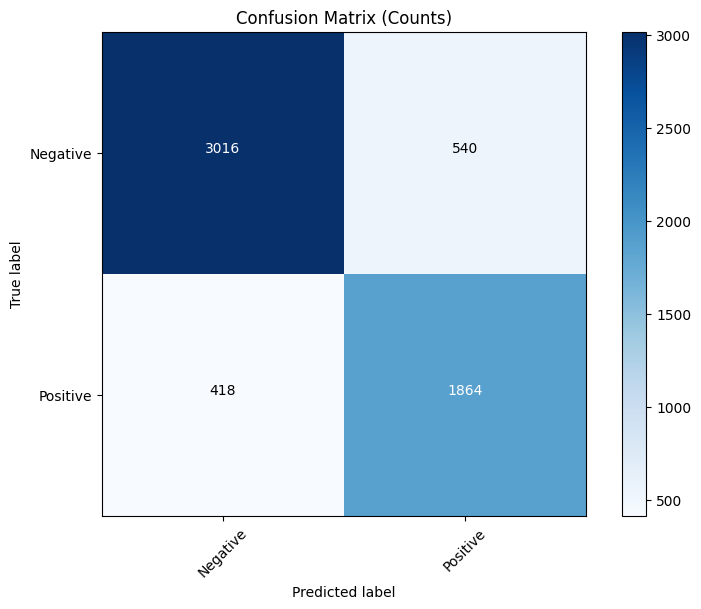

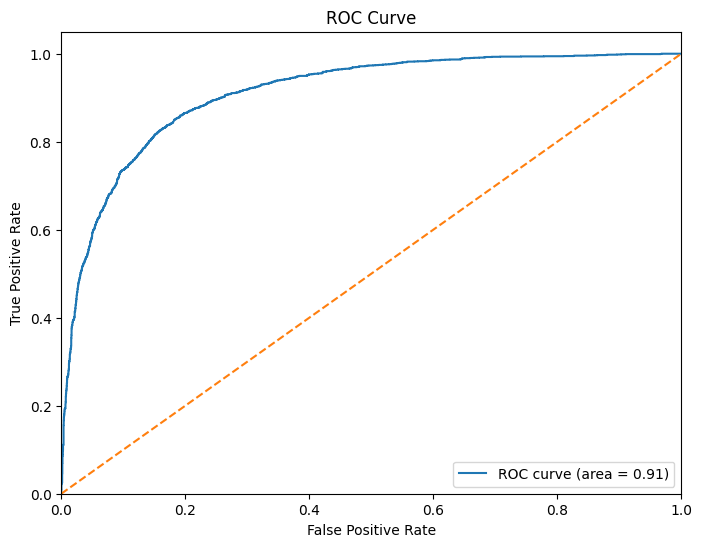


Training Linear SVM...
Training svm classifier...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Training completed in 7.91 seconds.
Best parameters: {'C': 0.1, 'class_weight': 'balanced', 'loss': 'squared_hinge'}
Best cross-validation F1 (macro): 0.8155

Linear SVM Evaluation:
Accuracy: 0.8350
Macro F1 Score: 0.8283

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.85      0.86      3556
           1       0.77      0.81      0.79      2282

    accuracy                           0.84      5838
   macro avg       0.83      0.83      0.83      5838
weighted avg       0.84      0.84      0.84      5838



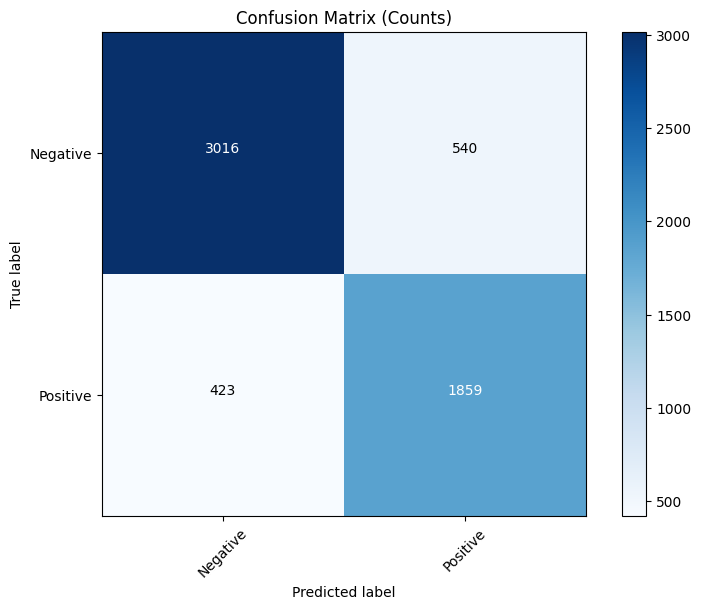

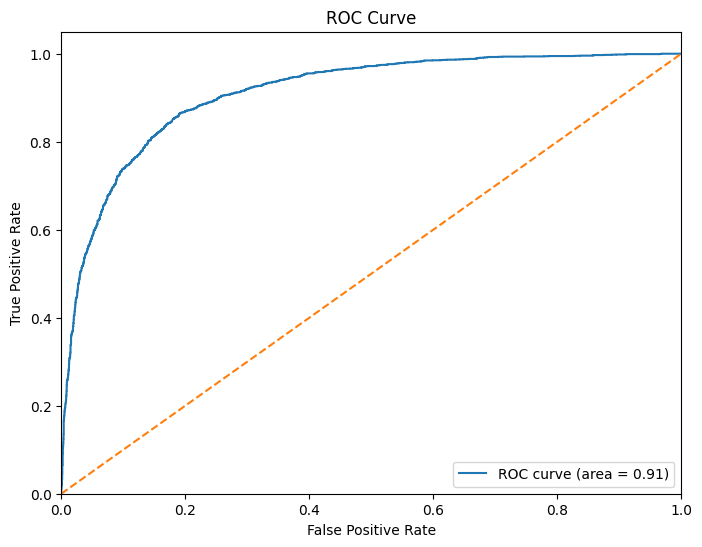


Training Naive Bayes...
Training nb classifier...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Training completed in 0.56 seconds.
Best parameters: {'alpha': 0.1}
Best cross-validation F1 (macro): 0.7904

Naive Bayes Evaluation:
Accuracy: 0.8111
Macro F1 Score: 0.7904

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.92      0.86      3556
           1       0.84      0.64      0.72      2282

    accuracy                           0.81      5838
   macro avg       0.82      0.78      0.79      5838
weighted avg       0.82      0.81      0.80      5838



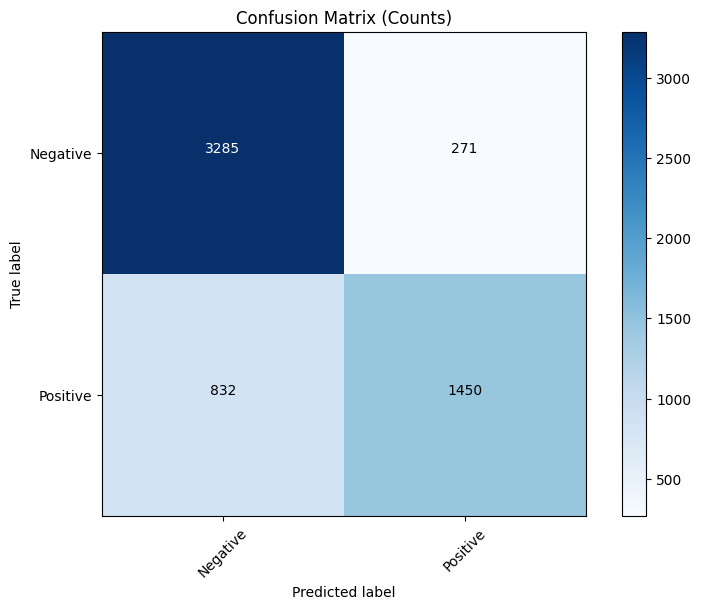

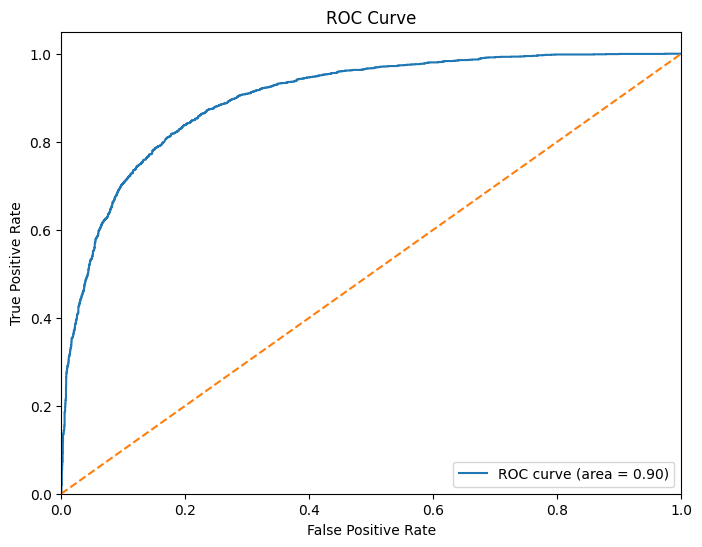


Model Comparison (Macro F1 Score):
LR: 0.8293
SVM: 0.8283
NB: 0.7904

BEST MODEL FOR BINARY CLASSIFICATION (CUTOFF = 3): LR
Macro F1 Score: 0.8293
Sample review: "The product is average. It meets expectations but there are issues with durability."
Predicted label (>3 or ≤3): 0
Predictions for cutoff=3 saved to 'binary_predictions_cutoff_3.csv'.


In [6]:
# BINARY CLASSIFICATION CUTOFF = 3

def binary_classification_cutoff_3(X, y_ratings, test_size=0.2, random_state=42):
    """
    Run binary classification experiment for cutoff = 3.
    """
    cutoff = 3
    y_binary = create_binary_labels(y_ratings, cutoff)
    
    X_train, X_val, y_train, y_val = train_test_split(
        X, y_binary, test_size=test_size, random_state=random_state, stratify=y_binary
    )
    
    print(f"\n{'='*80}")
    print(f"Binary Classification Experiment (Cutoff = {cutoff})")
    print(f"{'='*80}")
    print(f"Training samples: {X_train.shape[0]}")
    print(f"Validation samples: {X_val.shape[0]}")
    print(f"Positive class ratio (overall > {cutoff}): {y_binary.mean():.4f}")
    
    results = {}
    
    # Logistic Regression
    print("\nTraining Logistic Regression...")
    lr_param_grid = {
        'C': [0.1, 1.0, 10.0],
        'class_weight': [None, 'balanced'],
        'solver': ['liblinear', 'saga']
    }
    lr_model, lr_cv_results = train_binary_classifier(X_train, y_train, 'lr', lr_param_grid)
    print("\nLogistic Regression Evaluation:")
    lr_metrics = evaluate_classifier(lr_model, X_val, y_val)
    results['lr'] = {'model': lr_model, 'metrics': lr_metrics, 'cv_results': lr_cv_results}
    
    # Linear SVM
    print("\nTraining Linear SVM...")
    svm_param_grid = {
        'C': [0.1, 1.0, 10.0],
        'class_weight': [None, 'balanced'],
        'loss': ['hinge', 'squared_hinge']
    }
    svm_model, svm_cv_results = train_binary_classifier(X_train, y_train, 'svm', svm_param_grid)
    print("\nLinear SVM Evaluation:")
    svm_metrics = evaluate_classifier(svm_model, X_val, y_val)
    results['svm'] = {'model': svm_model, 'metrics': svm_metrics, 'cv_results': svm_cv_results}
    
    # Naive Bayes
    print("\nTraining Naive Bayes...")
    nb_param_grid = {'alpha': [0.01, 0.1, 1.0, 10.0]}
    nb_model, nb_cv_results = train_binary_classifier(X_train, y_train, 'nb', nb_param_grid)
    print("\nNaive Bayes Evaluation:")
    nb_metrics = evaluate_classifier(nb_model, X_val, y_val)
    results['nb'] = {'model': nb_model, 'metrics': nb_metrics, 'cv_results': nb_cv_results}
    
    # Compare models by Macro F1
    print("\nModel Comparison (Macro F1 Score):")
    for model_name, model_data in results.items():
        print(f"{model_name.upper()}: {model_data['metrics']['f1_score']:.4f}")
    
    return results


# --- Run experiment for cutoff=3 ---

if y_ratings is not None:
    results_cutoff_3 = binary_classification_cutoff_3(X_train_features, y_ratings)
    best_model_name_3 = max(
        results_cutoff_3.items(),
        key=lambda x: x[1]['metrics']['f1_score']
    )[0]
    best_model_3 = results_cutoff_3[best_model_name_3]['model']
    best_f1_score_3 = results_cutoff_3[best_model_name_3]['metrics']['f1_score']
    
    print(f"\n{'='*80}")
    print(f"BEST MODEL FOR BINARY CLASSIFICATION (CUTOFF = 3): {best_model_name_3.upper()}")
    print(f"Macro F1 Score: {best_f1_score_3:.4f}")
    print(f"{'='*80}")
    
    # Sample usage
    sample_review = "The product is average. It meets expectations but there are issues with durability."
    if best_model_3 is not None:
        vec_sample = vectorizer.transform([sample_review])
        pred = best_model_3.predict(vec_sample)[0]
        print(f"Sample review: \"{sample_review}\"")
        print(f"Predicted label (>3 or ≤3): {pred}")
        
    # generate predictions
    if (X_test_features is not None) and (processed_test is not None):
        test_predictions = best_model_3.predict(X_test_features)
        submission_df = pd.DataFrame({
            'id': processed_test.index,
            'binary_split_3': test_predictions
        })
        submission_df.to_csv('binary_predictions_cutoff_3.csv', index=False)
        print("Predictions for cutoff=3 saved to 'binary_predictions_cutoff_3.csv'.")


Binary Classification Experiment (Cutoff = 4)
Training samples: 23351
Validation samples: 5838
Positive class ratio (overall > 4): 0.1933

Training Logistic Regression...
Training lr classifier...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Training completed in 16.39 seconds.
Best parameters: {'C': 1.0, 'class_weight': 'balanced', 'solver': 'liblinear'}
Best cross-validation F1 (macro): 0.7685

Logistic Regression Evaluation:
Accuracy: 0.8338
Macro F1 Score: 0.7671

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.85      0.89      4710
           1       0.55      0.77      0.64      1128

    accuracy                           0.83      5838
   macro avg       0.74      0.81      0.77      5838
weighted avg       0.86      0.83      0.84      5838



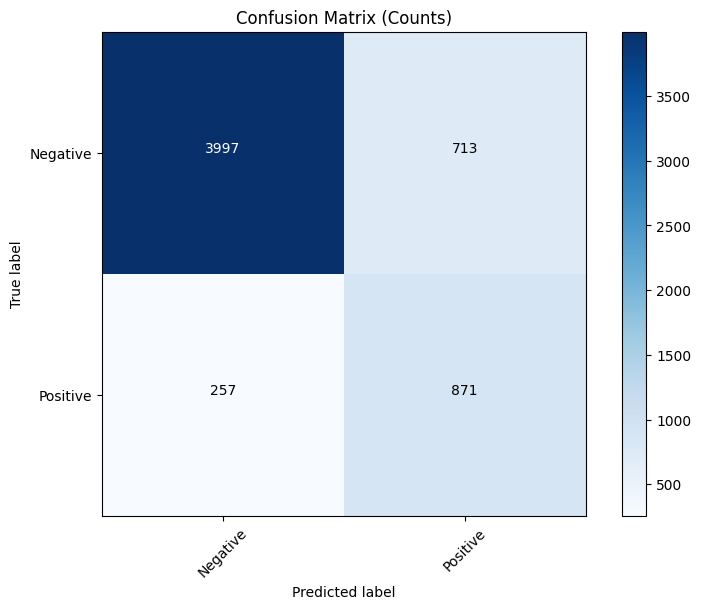

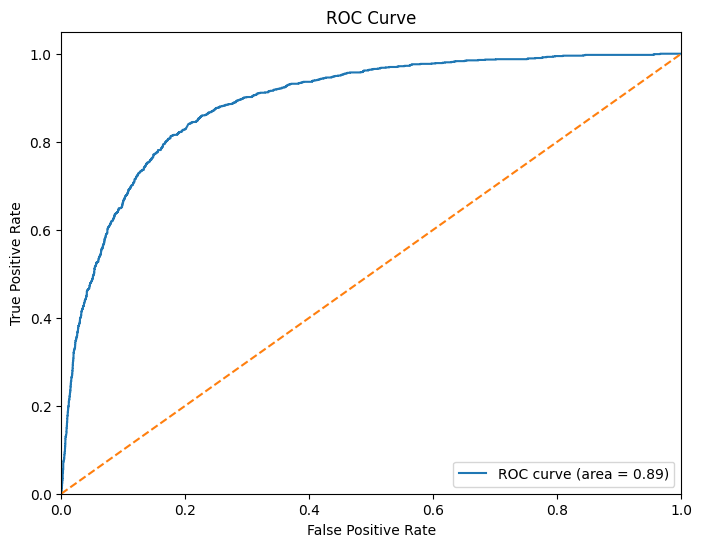


Training Linear SVM...
Training svm classifier...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Training completed in 8.16 seconds.
Best parameters: {'C': 0.1, 'class_weight': 'balanced', 'loss': 'squared_hinge'}
Best cross-validation F1 (macro): 0.7685

Linear SVM Evaluation:
Accuracy: 0.8326
Macro F1 Score: 0.7659

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.85      0.89      4710
           1       0.55      0.77      0.64      1128

    accuracy                           0.83      5838
   macro avg       0.74      0.81      0.77      5838
weighted avg       0.86      0.83      0.84      5838



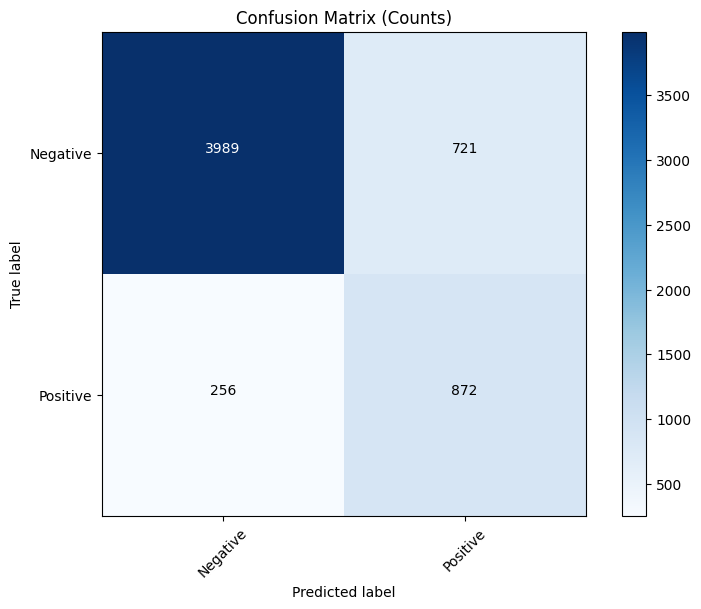

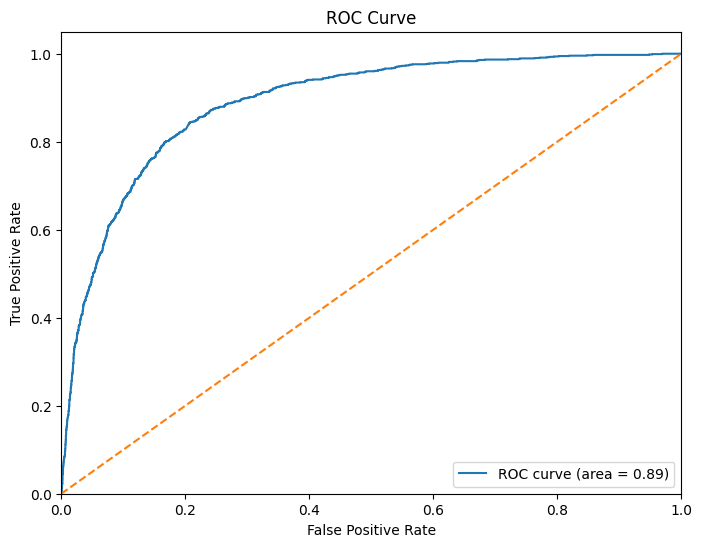


Training Naive Bayes...
Training nb classifier...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Training completed in 0.51 seconds.
Best parameters: {'alpha': 0.01}
Best cross-validation F1 (macro): 0.6649

Naive Bayes Evaluation:
Accuracy: 0.8458
Macro F1 Score: 0.6781

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.97      0.91      4710
           1       0.73      0.32      0.45      1128

    accuracy                           0.85      5838
   macro avg       0.79      0.65      0.68      5838
weighted avg       0.83      0.85      0.82      5838



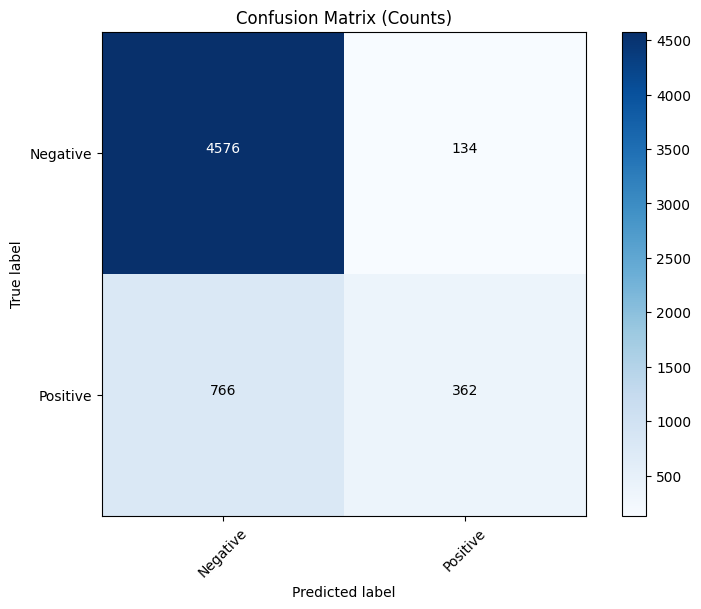

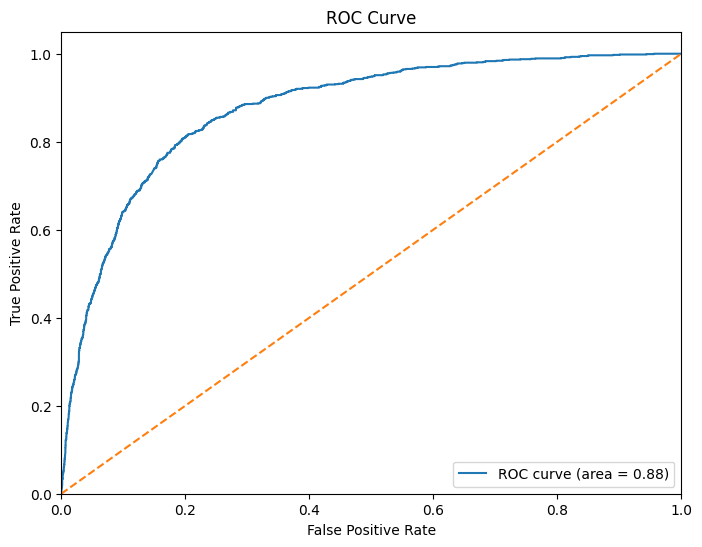


Model Comparison (Macro F1 Score):
LR: 0.7671
SVM: 0.7659
NB: 0.6781

BEST MODEL FOR BINARY CLASSIFICATION (CUTOFF = 4): LR
Macro F1 Score: 0.7671
Sample review: "This product is very good. It works well and I'm happy with my purchase, though there's room for improvement."
Predicted label (>4 or ≤4): 1
Predictions for cutoff=4 saved to 'binary_predictions_cutoff_4.csv'.


In [7]:
# BINARY CLASSIFICATION CUTOFF = 3

def binary_classification_cutoff_4(X, y_ratings, test_size=0.2, random_state=42):
    """
    Run binary classification experiment for cutoff = 4.
    """
    cutoff = 4
    y_binary = create_binary_labels(y_ratings, cutoff)
    
    X_train, X_val, y_train, y_val = train_test_split(
        X, y_binary, test_size=test_size, random_state=random_state, stratify=y_binary
    )
    
    print(f"\n{'='*80}")
    print(f"Binary Classification Experiment (Cutoff = {cutoff})")
    print(f"{'='*80}")
    print(f"Training samples: {X_train.shape[0]}")
    print(f"Validation samples: {X_val.shape[0]}")
    print(f"Positive class ratio (overall > {cutoff}): {y_binary.mean():.4f}")
    
    results = {}
    
    # Logistic Regression
    print("\nTraining Logistic Regression...")
    lr_param_grid = {
        'C': [0.1, 1.0, 10.0],
        'class_weight': [None, 'balanced'],
        'solver': ['liblinear', 'saga']
    }
    lr_model, lr_cv_results = train_binary_classifier(X_train, y_train, 'lr', lr_param_grid)
    print("\nLogistic Regression Evaluation:")
    lr_metrics = evaluate_classifier(lr_model, X_val, y_val)
    results['lr'] = {'model': lr_model, 'metrics': lr_metrics, 'cv_results': lr_cv_results}
    
    # Linear SVM
    print("\nTraining Linear SVM...")
    svm_param_grid = {
        'C': [0.1, 1.0, 10.0],
        'class_weight': [None, 'balanced'],
        'loss': ['hinge', 'squared_hinge']
    }
    svm_model, svm_cv_results = train_binary_classifier(X_train, y_train, 'svm', svm_param_grid)
    print("\nLinear SVM Evaluation:")
    svm_metrics = evaluate_classifier(svm_model, X_val, y_val)
    results['svm'] = {'model': svm_model, 'metrics': svm_metrics, 'cv_results': svm_cv_results}
    
    # Naive Bayes
    print("\nTraining Naive Bayes...")
    nb_param_grid = {'alpha': [0.01, 0.1, 1.0, 10.0]}
    nb_model, nb_cv_results = train_binary_classifier(X_train, y_train, 'nb', nb_param_grid)
    print("\nNaive Bayes Evaluation:")
    nb_metrics = evaluate_classifier(nb_model, X_val, y_val)
    results['nb'] = {'model': nb_model, 'metrics': nb_metrics, 'cv_results': nb_cv_results}
    
    # Compare models by Macro F1
    print("\nModel Comparison (Macro F1 Score):")
    for model_name, model_data in results.items():
        print(f"{model_name.upper()}: {model_data['metrics']['f1_score']:.4f}")
    
    return results


# --- Run experiment for cutoff=4 ---

if y_ratings is not None:
    results_cutoff_4 = binary_classification_cutoff_4(X_train_features, y_ratings)
    best_model_name_4 = max(
        results_cutoff_4.items(),
        key=lambda x: x[1]['metrics']['f1_score']
    )[0]
    best_model_4 = results_cutoff_4[best_model_name_4]['model']
    best_f1_score_4 = results_cutoff_4[best_model_name_4]['metrics']['f1_score']
    
    print(f"\n{'='*80}")
    print(f"BEST MODEL FOR BINARY CLASSIFICATION (CUTOFF = 4): {best_model_name_4.upper()}")
    print(f"Macro F1 Score: {best_f1_score_4:.4f}")
    print(f"{'='*80}")
    
    # Sample usage
    sample_review = "This product is very good. It works well and I'm happy with my purchase, though there's room for improvement."
    if best_model_4 is not None:
        vec_sample = vectorizer.transform([sample_review])
        pred = best_model_4.predict(vec_sample)[0]
        print(f"Sample review: \"{sample_review}\"")
        print(f"Predicted label (>4 or ≤4): {pred}")
        
    # Generate predictions for test dataset
    if (X_test_features is not None) and (processed_test is not None):
        test_predictions = best_model_4.predict(X_test_features)
        submission_df = pd.DataFrame({
            'id': processed_test.index,
            'binary_split_4': test_predictions
        })
        submission_df.to_csv('binary_predictions_cutoff_4.csv', index=False)
        print("Predictions for cutoff=4 saved to 'binary_predictions_cutoff_4.csv'.")


Starting Multiclass Classification (1 to 5 stars)...

Multiclass Classification Experiment (Ratings 1-5)
Training samples: 23351
Validation samples: 5838
Class distribution: [5957 5959 5862 5769 5642]

Training Multinomial Logistic Regression...
Training lr classifier...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Training completed in 30.33 seconds.
Best parameters: {'C': 1.0, 'class_weight': 'balanced'}
Best cross-validation F1 (macro): 0.4841

Logistic Regression Evaluation:
Accuracy: 0.4976
Macro F1 Score: 0.4955

Classification Report:
              precision    recall  f1-score   support

           1       0.58      0.61      0.60      1192
           2       0.39      0.36      0.37      1192
           3       0.42      0.41      0.42      1172
           4       0.47      0.44      0.45      1154
           5       0.61      0.67      0.64      1128

    accuracy                           0.50      5838
   macro avg       0.49      0.50      0.50      5838
we

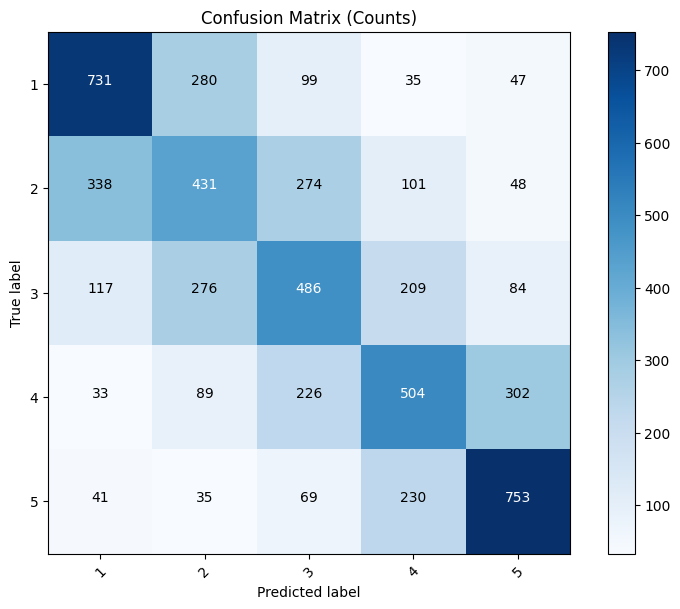

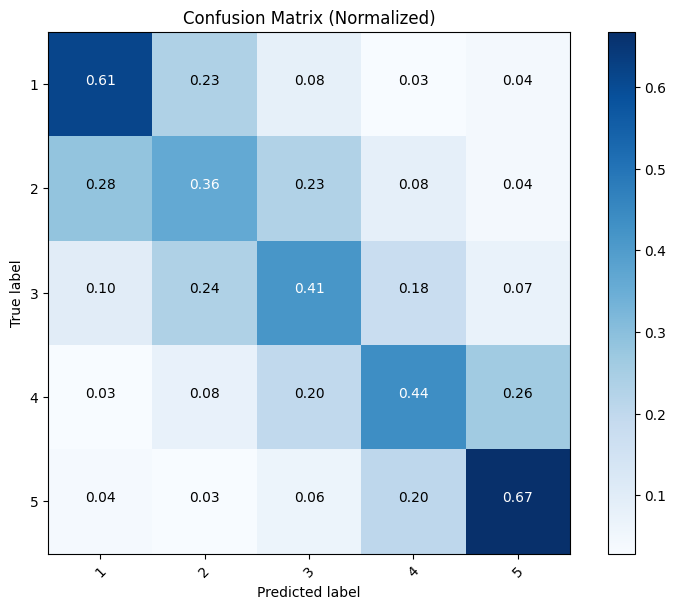

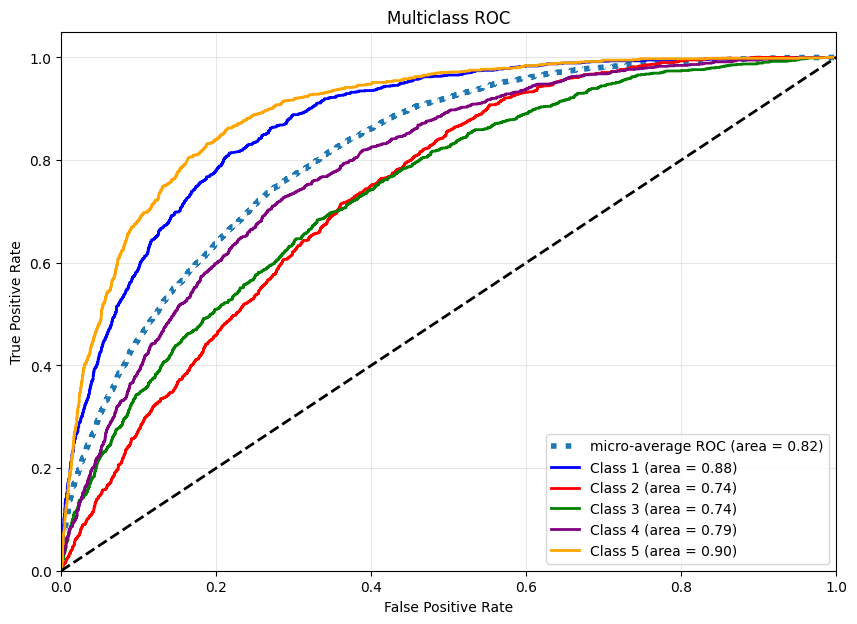


Training Linear SVM...
Training svm classifier...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Training completed in 44.28 seconds.
Best parameters: {'C': 0.1, 'class_weight': None}
Best cross-validation F1 (macro): 0.4822

Linear SVM Evaluation:
Accuracy: 0.4964
Macro F1 Score: 0.4883

Classification Report:
              precision    recall  f1-score   support

           1       0.55      0.67      0.61      1192
           2       0.40      0.32      0.35      1192
           3       0.43      0.39      0.41      1172
           4       0.46      0.41      0.43      1154
           5       0.59      0.70      0.64      1128

    accuracy                           0.50      5838
   macro avg       0.49      0.50      0.49      5838
weighted avg       0.48      0.50      0.49      5838



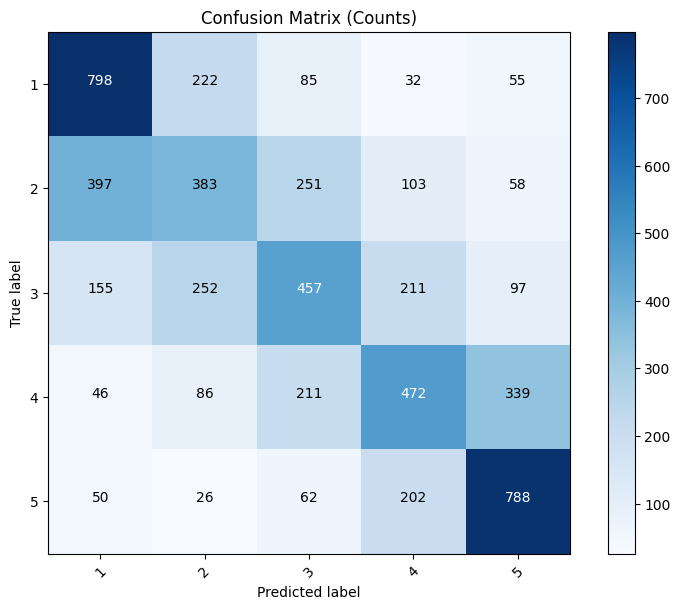

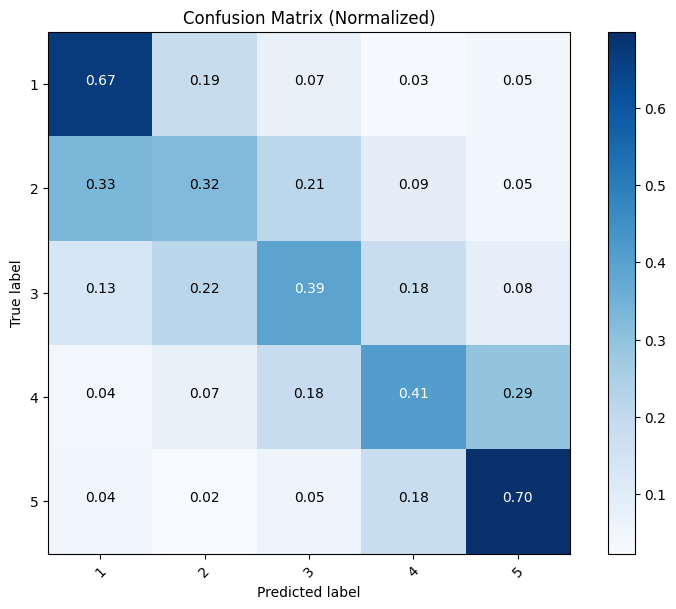

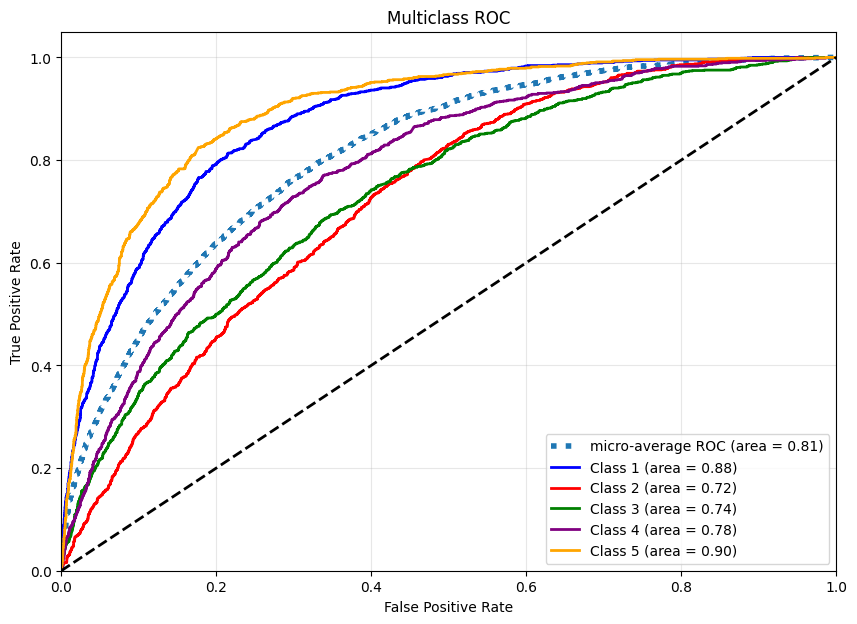


Training Multinomial Naive Bayes...
Training nb classifier...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Training completed in 0.56 seconds.
Best parameters: {'alpha': 1.0}
Best cross-validation F1 (macro): 0.4799

Naive Bayes Evaluation:
Accuracy: 0.4873
Macro F1 Score: 0.4858

Classification Report:
              precision    recall  f1-score   support

           1       0.56      0.63      0.59      1192
           2       0.37      0.37      0.37      1192
           3       0.42      0.42      0.42      1172
           4       0.45      0.40      0.43      1154
           5       0.62      0.62      0.62      1128

    accuracy                           0.49      5838
   macro avg       0.49      0.49      0.49      5838
weighted avg       0.48      0.49      0.48      5838



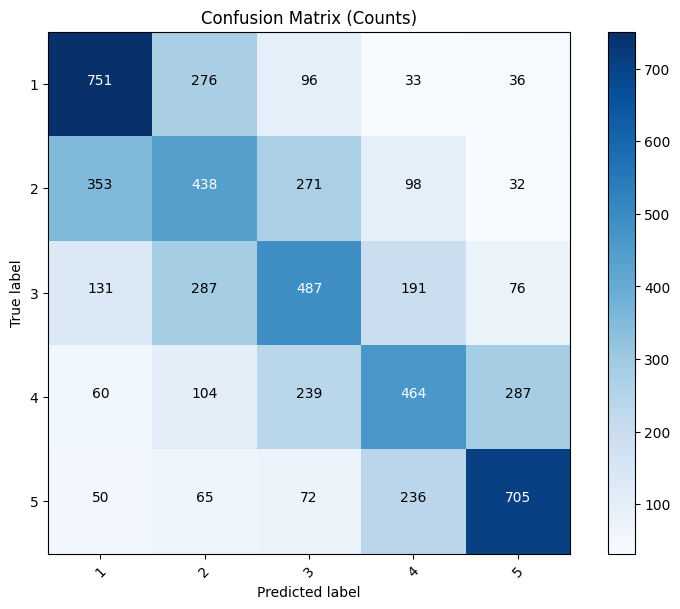

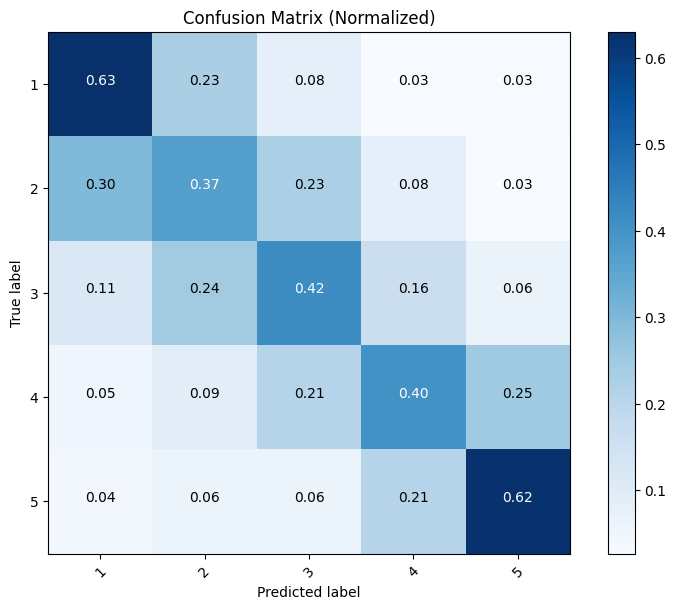

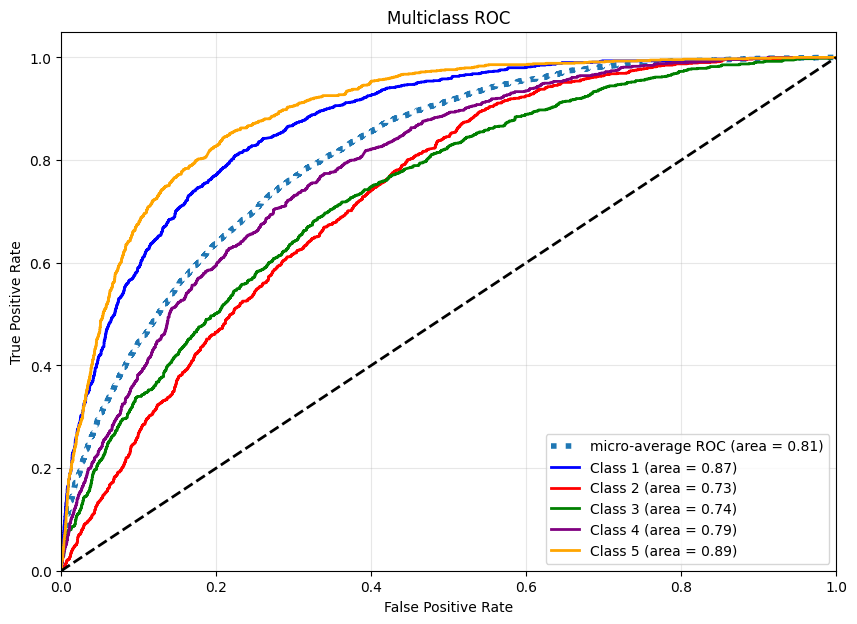


Training Random Forest...
Training rf classifier...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Training completed in 1964.42 seconds.
Best parameters: {'class_weight': None, 'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validation F1 (macro): 0.4429

Random Forest Evaluation:
Accuracy: 0.4589
Macro F1 Score: 0.4550

Classification Report:
              precision    recall  f1-score   support

           1       0.54      0.62      0.57      1192
           2       0.35      0.32      0.33      1192
           3       0.39      0.39      0.39      1172
           4       0.43      0.36      0.39      1154
           5       0.56      0.61      0.58      1128

    accuracy                           0.46      5838
   macro avg       0.45      0.46      0.45      5838
weighted avg       0.45      0.46      0.45      5838



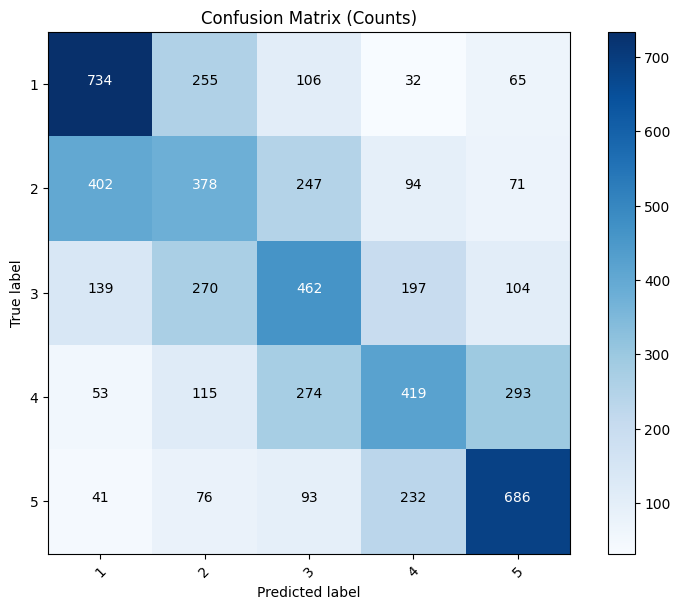

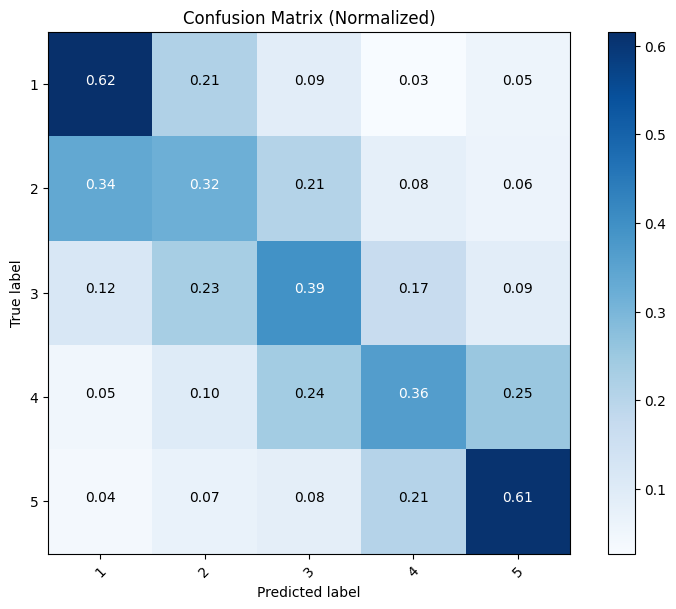

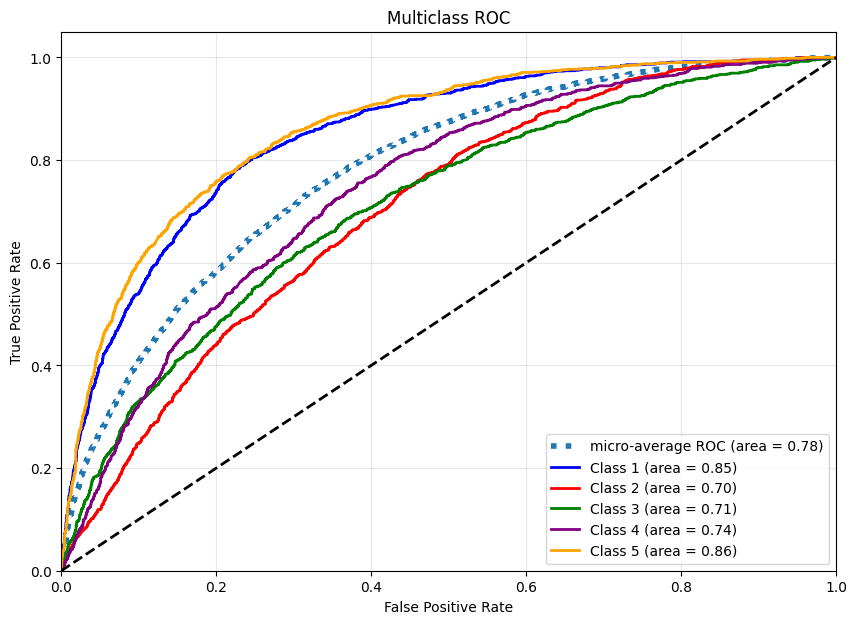


Model Comparison (Macro F1 Score):
LR: 0.4955
SVM: 0.4883
NB: 0.4858
RF: 0.4550

BEST MODEL FOR MULTICLASS CLASSIFICATION: LR
Macro F1 Score: 0.4955
Multiclass predictions saved to 'multiclass_predictions_1_to_5.csv'.


In [8]:
# MULTICLASS CLASSIFIER

def train_multiclass_classifier(X_train, y_train, model_type, param_grid, cv=5, n_jobs=-1):
    """
    Train a multiclass classifier using GridSearchCV.
    model_type can be: 'lr', 'svm', 'nb', or 'rf'.
    """
    if model_type == 'lr':
        # Multinomial Logistic Regression
        model = LogisticRegression(random_state=42, max_iter=1000, multi_class='multinomial', solver='saga')
    elif model_type == 'svm':
        # Linear SVM
        model = LinearSVC(random_state=42, max_iter=1000, dual=False)
    elif model_type == 'nb':
        model = MultinomialNB()
    elif model_type == 'rf':
        model = RandomForestClassifier(random_state=42, n_jobs=1)
    else:
        raise ValueError("model_type must be 'lr', 'svm', 'nb', or 'rf'")
    
    stratified_cv = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=stratified_cv,
        scoring='f1_macro',
        n_jobs=n_jobs,
        verbose=1,
        return_train_score=True
    )
    
    start_time = time.time()
    print(f"Training {model_type} classifier...")
    grid_search.fit(X_train, y_train)
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds.")
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation F1 (macro): {grid_search.best_score_:.4f}")
    
    return grid_search.best_estimator_, grid_search.cv_results_


def plot_multiclass_roc(y_test, y_score, n_classes=5, class_labels=None):
    """
    Plot ROC curves for multiclass classification (one-vs-rest).
    Expects y_test to be integer-coded 1..n_classes.
    """
    from sklearn.preprocessing import label_binarize
    
    # Binarize y_test
    y_test_bin = label_binarize(y_test, classes=np.arange(1, n_classes + 1))
    
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Micro-average
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    plt.figure(figsize=(10, 7))
    plt.plot(fpr["micro"], tpr["micro"],
             label=f"micro-average ROC (area = {roc_auc['micro']:.2f})",
             linestyle=':', linewidth=4)
    
    colors = ['blue', 'red', 'green', 'purple', 'orange']
    if class_labels is None:
        class_labels = [str(i+1) for i in range(n_classes)]
        
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'Class {class_labels[i]} (area = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multiclass ROC')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()
    
    return roc_auc


def evaluate_multiclass_classifier(clf, X_test, y_test, class_names=None):
    """
    Evaluate a multiclass classifier, printing metrics + confusion matrix + multiclass ROC.
    """
    y_pred = clf.predict(X_test)
    
    if hasattr(clf, "predict_proba"):
        y_score = clf.predict_proba(X_test)
    else:
        # Handle SVM or other classifiers without predict_proba
        if hasattr(clf, "decision_function"):
            # decision_function returns shape [n_samples, n_classes]
            decision_values = clf.decision_function(X_test)
            # Convert with softmax
            y_score = np.exp(decision_values) / np.sum(np.exp(decision_values), axis=1, keepdims=True)
        else:
            y_score = None
    
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    cm = confusion_matrix(y_test, y_pred)
    
    if class_names is None:
        class_names = [str(i+1) for i in range(len(np.unique(y_test)))]
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Macro F1 Score: {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Plot confusion matrices
    plot_confusion_matrix(cm, class_names, title='Confusion Matrix (Counts)', normalize=False)
    plot_confusion_matrix(cm, class_names, title='Confusion Matrix (Normalized)', normalize=True)
    
    # Multiclass ROC
    if (y_score is not None) and (len(np.unique(y_test)) > 2):
        plot_multiclass_roc(y_test, y_score, n_classes=len(class_names), class_labels=class_names)
    
    return {'accuracy': accuracy, 'f1_score': f1, 'confusion_matrix': cm}


def multiclass_classification_experiment(X, y_ratings, test_size=0.2, random_state=42):
    """
    Run a 5-class classification experiment for ratings 1..5.
    """
    X_train, X_val, y_train, y_val = train_test_split(
        X, y_ratings, test_size=test_size, random_state=random_state, stratify=y_ratings
    )
    
    print(f"\n{'='*80}")
    print("Multiclass Classification Experiment (Ratings 1-5)")
    print(f"{'='*80}")
    print(f"Training samples: {X_train.shape[0]}")
    print(f"Validation samples: {X_val.shape[0]}")
    print(f"Class distribution: {np.bincount(y_ratings)[1:]}")  # bincount indexes from 0
    
    results = {}
    
    # Logistic Regression
    print("\nTraining Multinomial Logistic Regression...")
    lr_param_grid = {
        'C': [0.1, 1.0, 10.0],
        'class_weight': [None, 'balanced']
    }
    lr_model, lr_cv_results = train_multiclass_classifier(X_train, y_train, 'lr', lr_param_grid)
    print("\nLogistic Regression Evaluation:")
    lr_metrics = evaluate_multiclass_classifier(lr_model, X_val, y_val)
    results['lr'] = {'model': lr_model, 'metrics': lr_metrics, 'cv_results': lr_cv_results}
    
    # Linear SVM
    print("\nTraining Linear SVM...")
    svm_param_grid = {
        'C': [0.1, 1.0, 10.0],
        'class_weight': [None, 'balanced']
    }
    svm_model, svm_cv_results = train_multiclass_classifier(X_train, y_train, 'svm', svm_param_grid)
    print("\nLinear SVM Evaluation:")
    svm_metrics = evaluate_multiclass_classifier(svm_model, X_val, y_val)
    results['svm'] = {'model': svm_model, 'metrics': svm_metrics, 'cv_results': svm_cv_results}
    
    # Naive Bayes
    print("\nTraining Multinomial Naive Bayes...")
    nb_param_grid = {
        'alpha': [0.01, 0.1, 1.0, 10.0]
    }
    nb_model, nb_cv_results = train_multiclass_classifier(X_train, y_train, 'nb', nb_param_grid)
    print("\nNaive Bayes Evaluation:")
    nb_metrics = evaluate_multiclass_classifier(nb_model, X_val, y_val)
    results['nb'] = {'model': nb_model, 'metrics': nb_metrics, 'cv_results': nb_cv_results}
    
    # Random Forest
    print("\nTraining Random Forest...")
    rf_param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [None, 20],
        'min_samples_split': [2, 5],
        'class_weight': [None, 'balanced']
    }
    rf_model, rf_cv_results = train_multiclass_classifier(X_train, y_train, 'rf', rf_param_grid)
    print("\nRandom Forest Evaluation:")
    rf_metrics = evaluate_multiclass_classifier(rf_model, X_val, y_val)
    results['rf'] = {'model': rf_model, 'metrics': rf_metrics, 'cv_results': rf_cv_results}
    
    # Compare
    print("\nModel Comparison (Macro F1 Score):")
    for model_name, data in results.items():
        print(f"{model_name.upper()}: {data['metrics']['f1_score']:.4f}")
    
    return results


# --- Run multiclass experiment ---

if y_ratings is not None:
    print("\nStarting Multiclass Classification (1 to 5 stars)...")
    multiclass_results = multiclass_classification_experiment(X_train_features, y_ratings)
    
    best_model_name_mc = max(
        multiclass_results.items(),
        key=lambda x: x[1]['metrics']['f1_score']
    )[0]
    best_model_mc = multiclass_results[best_model_name_mc]['model']
    best_f1_score_mc = multiclass_results[best_model_name_mc]['metrics']['f1_score']
    
    print(f"\n{'='*80}")
    print(f"BEST MODEL FOR MULTICLASS CLASSIFICATION: {best_model_name_mc.upper()}")
    print(f"Macro F1 Score: {best_f1_score_mc:.4f}")
    print(f"{'='*80}")
    
    # Generate predictions for the test set
    if (X_test_features is not None) and (processed_test is not None):
        test_predictions = best_model_mc.predict(X_test_features)
        submission_df = pd.DataFrame({
            'id': processed_test.index,
            'predicted_rating': test_predictions
        })
        submission_df.to_csv('multiclass_predictions_1_to_5.csv', index=False)
        print("Multiclass predictions saved to 'multiclass_predictions_1_to_5.csv'.")

In [14]:
# CLUSTERING

df_test_multi = test_df.copy()
df_test_multi['verified'] = df_test_multi['verified'].astype(int)

# Fill missing numeric values
df_test_multi['vote'] = df_test_multi['vote'].fillna(0)
df_test_multi['unixReviewTime'] = df_test_multi['unixReviewTime'].fillna(
    df_test_multi['unixReviewTime'].median()
)

# collumn transformer

text_col = 'reviewText'
numeric_cols = ['verified', 'vote', 'unixReviewTime']

column_trans = ColumnTransformer(
    transformers=[
        ('text_tfidf', TfidfVectorizer(
            max_features=3000,
            stop_words='english',
            ngram_range=(1,2),
            min_df=2
        ), text_col),
        ('numeric_scaled', StandardScaler(), numeric_cols)
    ],
    remainder='drop'
)

# Fit the column transformer and transform the data
X_combined = column_trans.fit_transform(df_test_multi)

# Reduce dimensionality with TruncatedSVD
svd = TruncatedSVD(n_components=100, random_state=42)
X_svd = svd.fit_transform(X_combined)

# Try multiple k values
k_values = range(2, 11)
best_k = None
best_sil = -1
best_labels = None

for k in k_values:
    km = KMeans(
        n_clusters=k,
        random_state=42,
        n_init=10,
        max_iter=300
    )
    km.fit(X_svd)
    labels = km.labels_
    
    sil = silhouette_score(X_svd, labels)
    print(f"k = {k}, Silhouette = {sil:.4f}")
    
    if sil > best_sil:
        best_sil = sil
        best_k = k
        best_labels = labels

print("\nBest k:", best_k, "with Silhouette =", round(best_sil, 4))

# Evaluate ARI
true_category = LabelEncoder().fit_transform(df_test_multi['category'])
ari = adjusted_rand_score(true_category, best_labels)
print("ARI with best_k:", round(ari, 4))


k = 2, Silhouette = 0.6159
k = 3, Silhouette = 0.6160
k = 4, Silhouette = 0.5978
k = 5, Silhouette = 0.6067
k = 6, Silhouette = 0.2934
k = 7, Silhouette = 0.2692
k = 8, Silhouette = 0.2363
k = 9, Silhouette = 0.2384
k = 10, Silhouette = 0.2438

Best k: 3 with Silhouette = 0.616
ARI with best_k: 0.0456
